In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#class imbalance is one fo the challenges faced by this dataset, one effective solution for it is oversampling which is performed here:

In [ ]:
import os
import numpy as np
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
data_dir = '/content/drive/MyDrive/DL/traffic_Data/DATA'


In [ ]:
import pandas as pd
labels_data = pd.read_csv('/content/drive/MyDrive/DL/labels.csv')

In [ ]:
images = []
labels = []

In [ ]:
for class_folder in os.listdir(data_dir):
    class_id = int(class_folder)
    class_path = os.path.join(data_dir, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        class_name = labels_data.loc[labels_data['ClassId'] == class_id, 'Name'].iloc[0]
        labels.append(class_name)

In [ ]:
max_height = max(img.shape[0] for img in images)
max_width = max(img.shape[1] for img in images)

In [ ]:
resized_images = []
for img in images:
    resized_img = cv2.resize(img, (224, 224))
    resized_images.append(resized_img)

In [ ]:
images = np.array(resized_images)
labels = np.array(labels)

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
max_count = np.max(label_counts)

In [ ]:
oversampled_images = []
oversampled_labels = []

In [ ]:
for label, count in zip(unique_labels, label_counts):
    label_images = images[oversampled_labels == label]
    num_to_duplicate = max_count - count
    if num_to_duplicate > 0:

        oversampled_images.extend(label_images)
        oversampled_labels.extend([label] * num_to_duplicate)

In [ ]:
print(images.shape , labels.shape)

(4173, 224, 224, 3) (4173,)


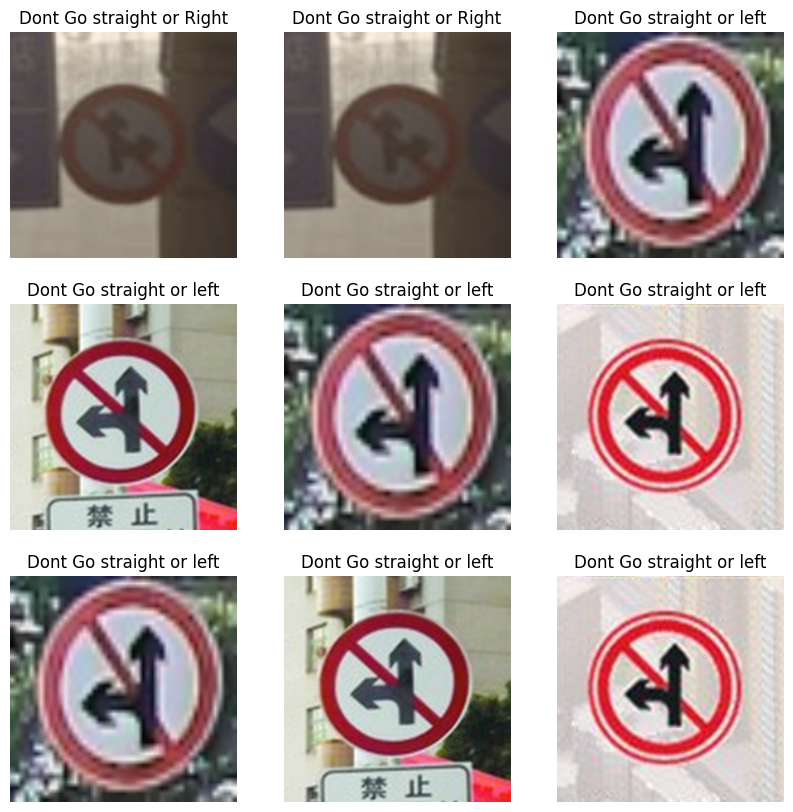

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

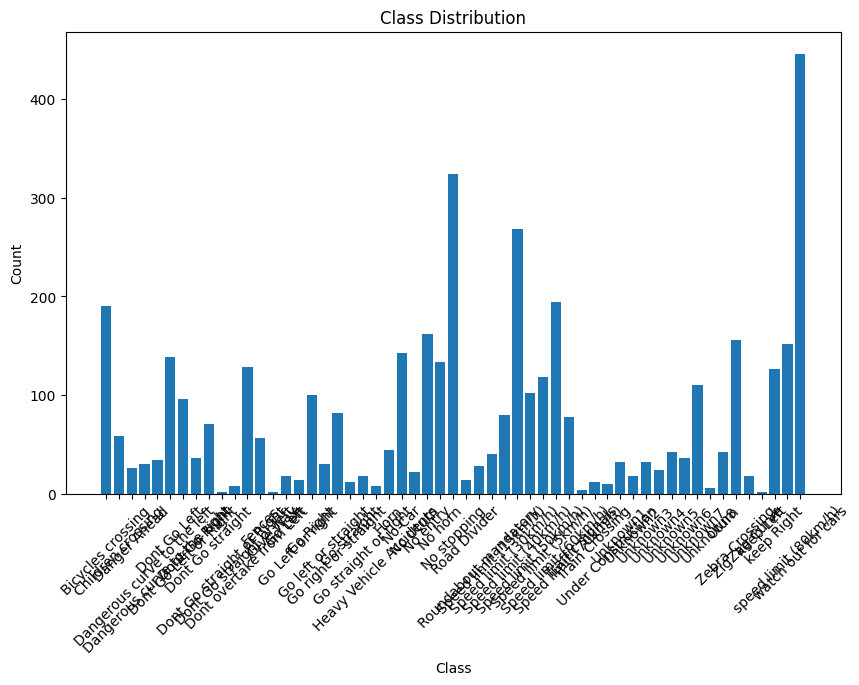

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load VGG16 model with imagenet weights and remove the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(len(unique_labels), activation='softmax')(x)

In [ ]:
# Create the model
vgg_model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# Compile the model
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Print model summary
vgg_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Define checkpoint to save the best model
checkpoint_path = "model_weights.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='min',
                                      save_freq='epoch')

In [ ]:
# Split the data into training and testing sets
X_train_resized, X_test_resized, y_train, y_test = train_test_split(np.array(resized_images), labels, test_size=0.2, random_state=42)

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Train the model
history = vgg_model.fit(X_train_resized, y_train_encoded,
                         epochs=10,
                         batch_size=32,
                         validation_data=(X_test_resized, y_test_encoded),
                         callbacks=[checkpoint_callback])


Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 1.6323 - accuracy: 0.6806 
Epoch 1: val_loss improved from inf to 0.44784, saving model to model_weights.h5
105/105 [==============================] - 1605s 15s/step - loss: 1.6323 - accuracy: 0.6806 - val_loss: 0.4478 - val_accuracy: 0.8850
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9512 
Epoch 2: val_loss improved from 0.44784 to 0.23554, saving model to model_weights.h5
105/105 [==============================] - 1599s 15s/step - loss: 0.1992 - accuracy: 0.9512 - val_loss: 0.2355 - val_accuracy: 0.9365
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9892 
Epoch 3: val_loss improved from 0.23554 to 0.10810, saving model to model_weights.h5
105/105 [==============================] - 1599s 15s/step - loss: 0.0641 - accuracy: 0.9892 - val_loss: 0.1081 - val_accuracy: 0.9808
Epoch 4/10
105/105 [==============================] - ET

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = vgg_model.evaluate(X_test_resized, y_test_encoded)
print("Test Accuracy:", test_acc)

27/27 [==============================] - 322s 12s/step - loss: 0.0725 - accuracy: 0.9904
Test Accuracy: 0.9904191493988037


In [ ]:
# Get intermediate layer outputs
layer_outputs = [layer.output for layer in vgg_model.layers]
activation_model = Model(inputs=vgg_model.input, outputs=layer_outputs)

In [ ]:
# Get activations for a sample image
sample_image = X_train_resized[0:1]
activations = activation_model.predict(sample_image)

1/1 [==============================] - 1s 755ms/step


input_2 (1, 224, 224, 3)


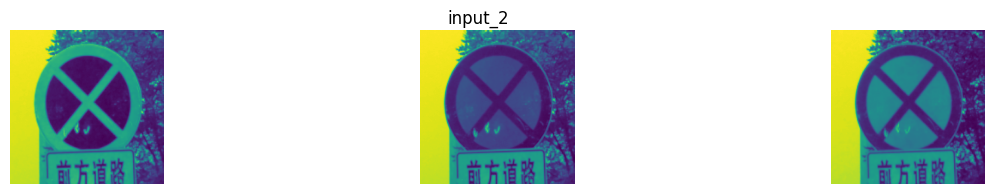

block1_conv1 (1, 224, 224, 64)


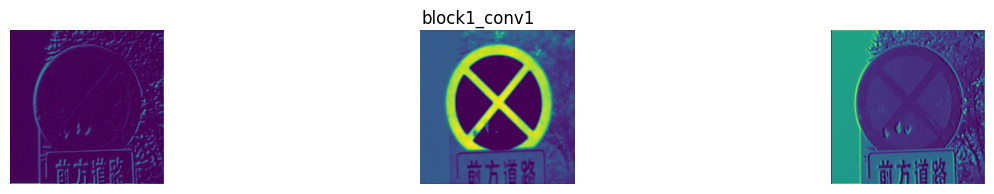

block1_conv2 (1, 224, 224, 64)


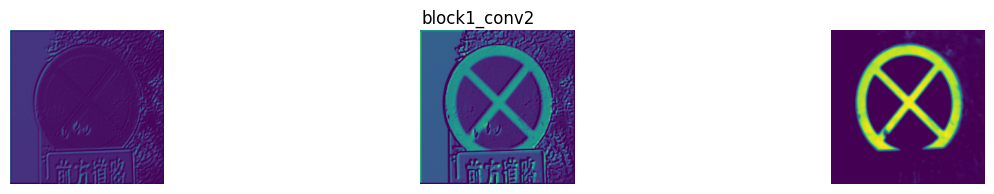

block1_pool (1, 112, 112, 64)


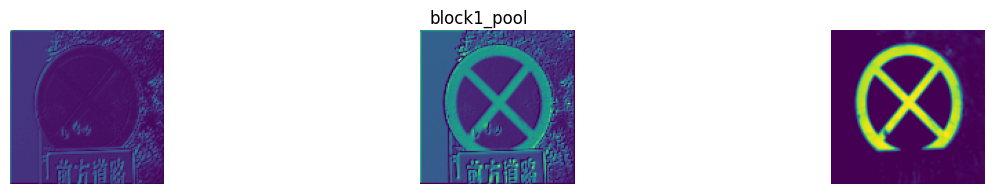

block2_conv1 (1, 112, 112, 128)


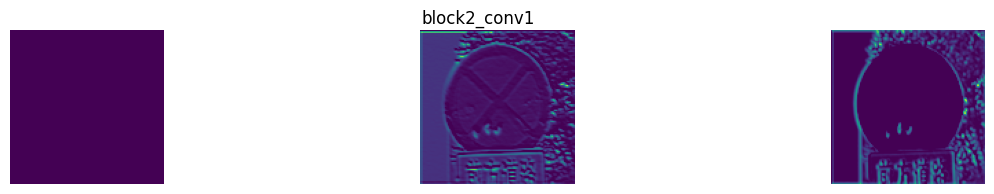

block2_conv2 (1, 112, 112, 128)


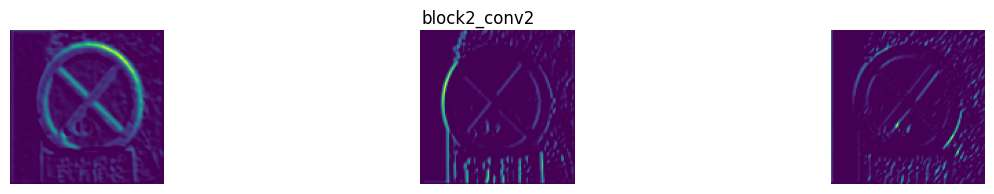

block2_pool (1, 56, 56, 128)


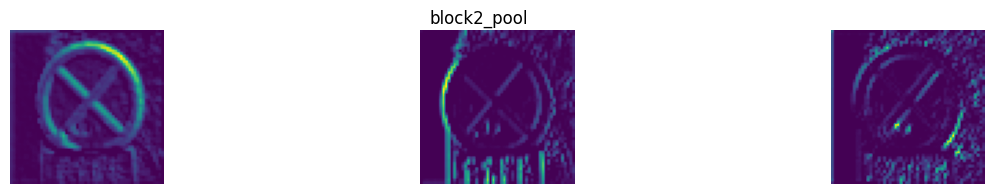

block3_conv1 (1, 56, 56, 256)


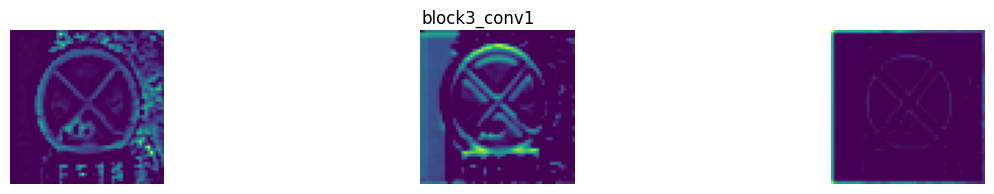

block3_conv2 (1, 56, 56, 256)


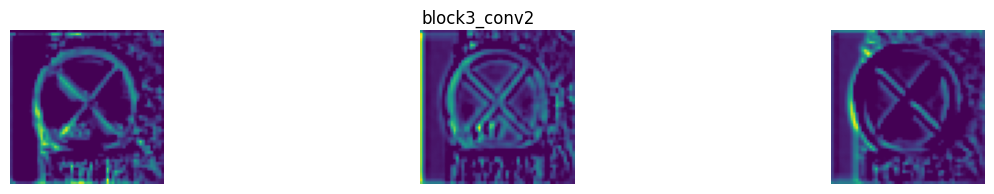

block3_conv3 (1, 56, 56, 256)


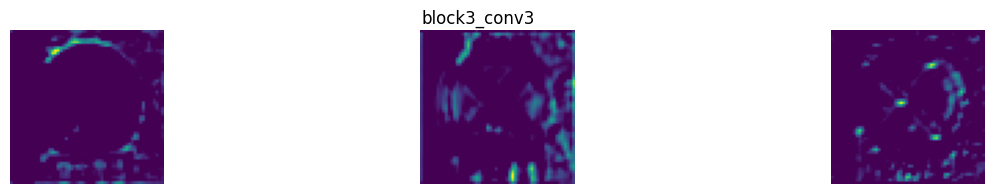

block3_pool (1, 28, 28, 256)


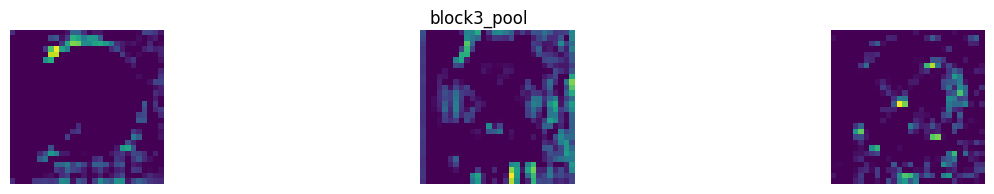

block4_conv1 (1, 28, 28, 512)


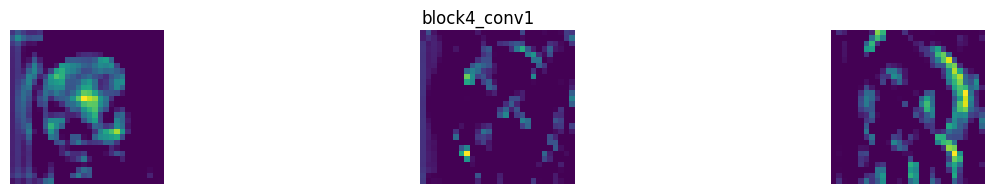

block4_conv2 (1, 28, 28, 512)


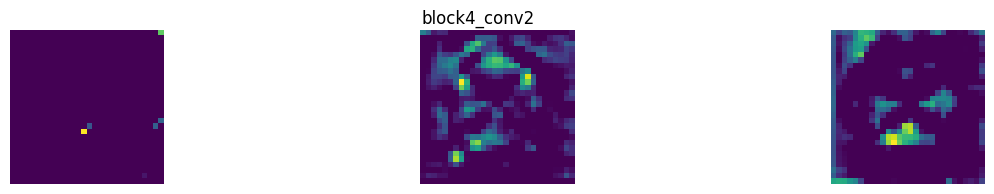

block4_conv3 (1, 28, 28, 512)


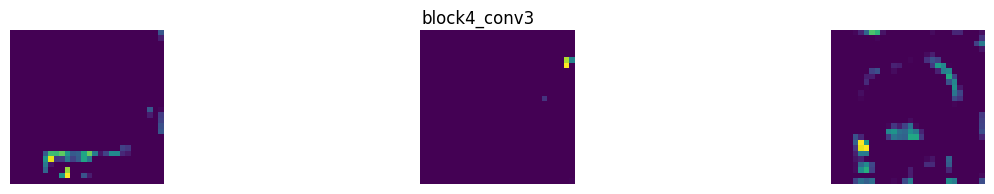

block4_pool (1, 14, 14, 512)


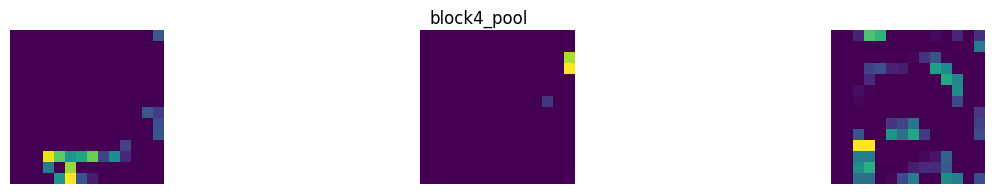

block5_conv1 (1, 14, 14, 512)


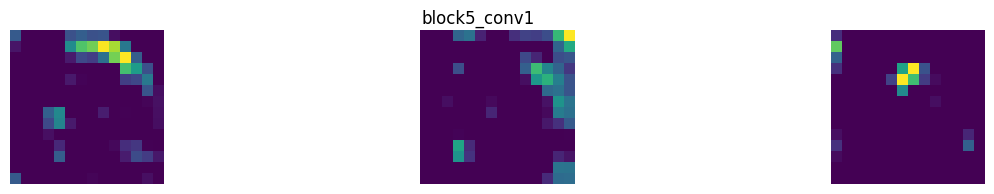

block5_conv2 (1, 14, 14, 512)


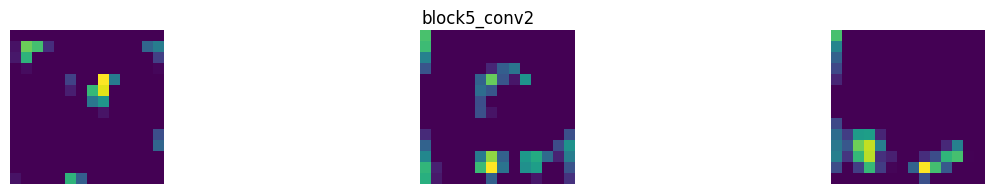

block5_conv3 (1, 14, 14, 512)


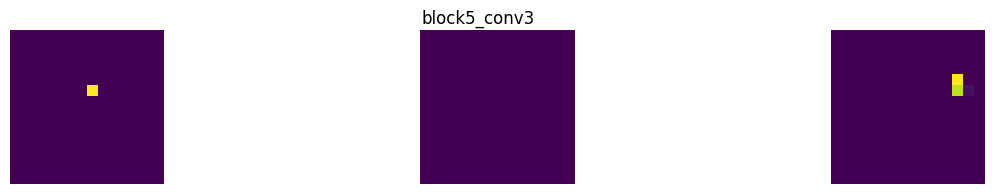

block5_pool (1, 7, 7, 512)


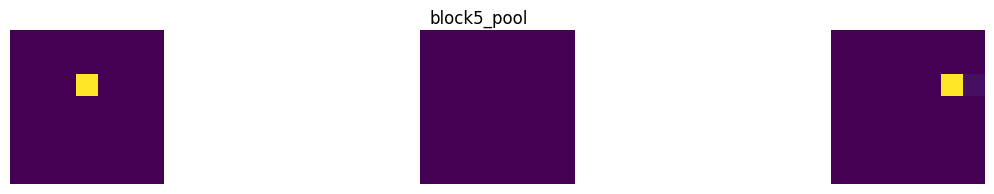

global_average_pooling2d_1 (1, 512)
dense_2 (1, 256)
dense_3 (1, 55)


In [ ]:
import matplotlib.pyplot as plt

# Define the maximum number of images to display for each layer
max_images = 3

# Loop through each layer and its corresponding activation
for layer_name, activation in zip(vgg_model.layers, activations):
    print(layer_name.name, activation.shape)
    if len(activation.shape) == 4:  # Check if the activation is of shape (batch_size, height, width, channels)
        # Create a row of subplots
        num_channels = min(activation.shape[-1], max_images)
        fig, axes = plt.subplots(1, num_channels, figsize=(15, 2))
        fig.suptitle(layer_name.name)

        # Visualize each channel in a subplot
        for i in range(num_channels):
            axes[i].imshow(activation[0, :, :, i], cmap='viridis')
            axes[i].axis('off')

        plt.show()


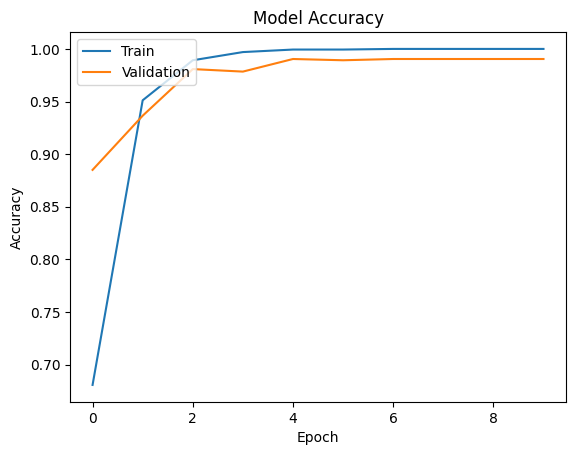

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


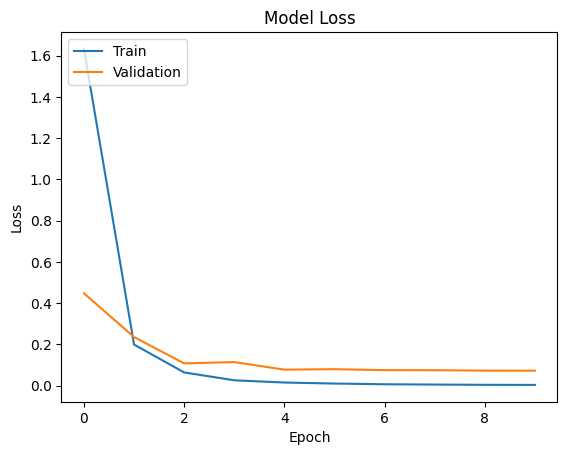

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


27/27 [==============================] - 327s 12s/step


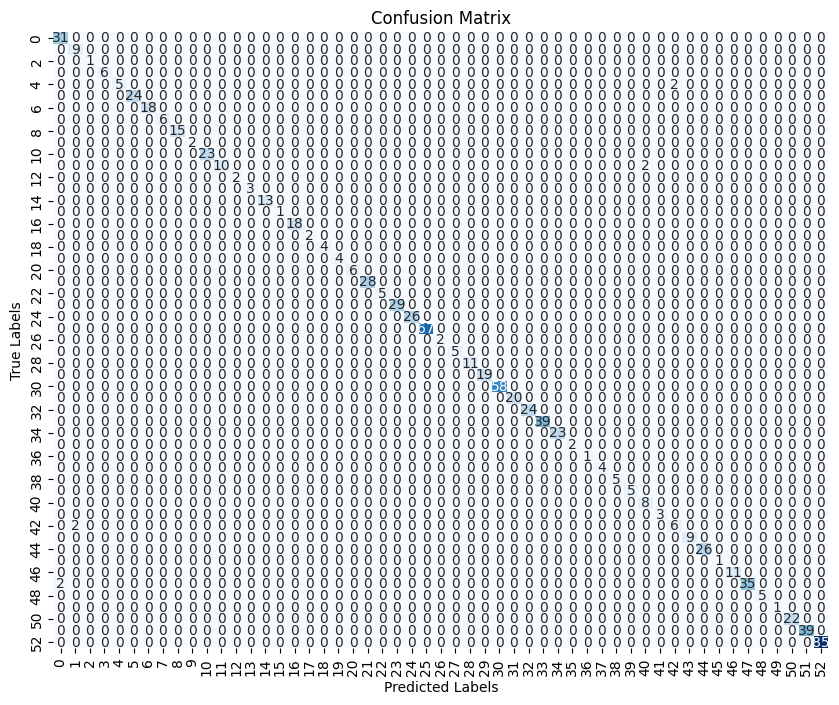

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        31
           1       0.82      1.00      0.90         9
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         6
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        15
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00        23
          12       1.00      0.83      0.91        12
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00        13
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00        18
          19       1.00    

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict labels for the test data
y_pred = vgg_model.predict(X_test_resized)
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_test_encoded, y_pred_labels))
